# Project 3
## Asma Akhtar
### 11/25/2024

# What are the top 5 highly rated gyms with the best sentiments?

In [3]:
import requests
import yelpkeys 
import json
import requests

import pandas as pd

from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from operator import itemgetter #getting top 20 words


import urllib
from urllib.parse import quote

# data visualization imports
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

# natural language processing
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from operator import itemgetter


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pakas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
API_KEY = yelpkeys.api_key

In [7]:
# API constants, you shouldn't have to change these.
API_KEY="9F_s1ES7zWFSsWT8SlhxAhOVK-Tk_5jGtGgyiJhnct4cDXrGdjAMkMdmmeYTqRdVTEJXbWTPCdAh1fas6JAkQrYLhZ9rWbsVXlhIePicia5XV1UOcb3BryAjn986ZHYx"
API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_REVIEWSPATH = '/v3/businesses/'  


# Defaults for our simple example.
DEFAULT_TERM = 'gyms'    # Focus is on gym category 
DEFAULT_LOCATION = 'Jersey City, NJ'# Specific location for the gyms in this region 
SEARCH_LIMIT = 20  # Searching for 20 businesses

In [9]:
# Function to query Yelp API and locate the list of businesses 
def request_yelp(host, path, api_key, url_params=None):
    """Given your API_KEY, send a GET request to the API.
    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        API_KEY (str): Your API Key.
        url_params (dict): An optional set of query parameters in the request.
    Returns:
        dict: The JSON response from the request.
    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }

    print(u'Querying {0} ...'.format(url))

    response = requests.request('GET', url, headers=headers, params=url_params)

    return response.json()

In [11]:
# create function to search yelp for businesses
def search(api_key, term, location):
    """Query the Search API by a search term and location.
    Args:
        term (str): The search term passed to the API.
        location (str): The search location passed to the API.
    Returns:
        dict: The JSON response from the request.
    """

    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': SEARCH_LIMIT
    }
    return request_yelp(API_HOST, SEARCH_PATH, api_key, url_params=url_params)


In [13]:
# Function to get reviews for a business
def get_reviews(api_key, business_id):
    review_path = f"/v3/businesses/{business_id}/reviews"
    reviews = request_yelp(API_HOST, review_path, api_key)
    return reviews


## Collect all the reviews of the gyms from all location in Jersey City, New Jersey

In [15]:
# Function to collect reviews from multiple businesses
def collect_reviews(api_key, term, location, min_reviews=60):
    all_reviews = []
    business_list = search(api_key, term, location)['businesses']

    # Collect reviews for businesses
    for business in business_list:
        business_id = business['id']
        reviews = get_reviews(api_key, business_id)
        
        for review in reviews.get('reviews', []):
            all_reviews.append({'business_name': business['name'], 
                                'review': review['text'], 
                                'rating': business['rating']})  # Ensure we include the 'rating' field
            
            if len(all_reviews) >= min_reviews:
                break
        if len(all_reviews) >= min_reviews:
            break
    return pd.DataFrame(all_reviews)

# Run the function to collect reviews
reviews_df = collect_reviews(API_KEY, DEFAULT_TERM, DEFAULT_LOCATION)
print(reviews_df.head())  # Display first few reviews to ensure it's working

Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/M_6BIcBpJkMw_ctQa203-A/reviews ...
Querying https://api.yelp.com/v3/businesses/8cicyQ8j8YETAeOTcLqXKg/reviews ...
Querying https://api.yelp.com/v3/businesses/OnP7Oj26mp3KQXfjRhxhbg/reviews ...
Querying https://api.yelp.com/v3/businesses/b1izLnJRUk2_9tLhOtkSCA/reviews ...
Querying https://api.yelp.com/v3/businesses/z1PzOjI6hwie850KH_pvdQ/reviews ...
Querying https://api.yelp.com/v3/businesses/HnVLDq7iywnLdTeUlk_gtQ/reviews ...
Querying https://api.yelp.com/v3/businesses/HDTrv1gXoOOeMvQ04ehzRA/reviews ...
Querying https://api.yelp.com/v3/businesses/8YnFKNYTiBa1L-6OVgp5rA/reviews ...
Querying https://api.yelp.com/v3/businesses/0T88HCCZjHW5AJnloL_UDg/reviews ...
Querying https://api.yelp.com/v3/businesses/2UPqLPZTCyIvGtYfOnjCTw/reviews ...
Querying https://api.yelp.com/v3/businesses/C9N_-wnhQhcI6teGrqHeJA/reviews ...
Querying https://api.yelp.com/v3/businesses/nTrTiWqBfLjdxjg6DmAFtA/reviews .

## Here we will show the business name, review text, and sentiment classifications from both methods (TextBlob and NaiveBayes).

In [17]:
# create function for TextBlob Sentiment Analysis
def textblob_sentiment(review_text):
    blob = TextBlob(review_text)
    sentiment_score = blob.sentiment.polarity
    # Classify based on sentiment score
    if sentiment_score > 0:
        return 'Positive'
    elif sentiment_score < 0:
        return 'Negative'
    else:
        return 'Neutral'

# create function for NaiveBayesAnalyzer Sentiment Analysis
def naivebayes_sentiment(review_text):
    analyzer = NaiveBayesAnalyzer()
    analysis = analyzer.analyze(review_text)
    # Return the classification (positive, negative, or neutral)
    return analysis.classification

# creating function to apply both sentiment analysis methods and store results
def analyze_sentiments(reviews_df):
    reviews_df['textblob_sentiment'] = reviews_df['review'].apply(textblob_sentiment)
    reviews_df['naivebayes_sentiment'] = reviews_df['review'].apply(naivebayes_sentiment)
    
    return reviews_df

# Perform sentiment analysis on the raw reviews
reviews_df = analyze_sentiments(reviews_df)

# print the results of sentiment analysis
print(reviews_df[['business_name', 'review', 'textblob_sentiment', 'naivebayes_sentiment']].head())

  business_name                                             review  \
0          Base  Stepping into this gym feels like entering a s...   
1          Base  I like to do periodic reviews of BASE (gym) at...   
2          Base  Ultimately  the amenities are not worth the co...   
3  Four Fitness  It is a boutique gym that is a hidden gem in t...   
4  Four Fitness  A small, comforting gym that has everything yo...   

  textblob_sentiment naivebayes_sentiment  
0            Neutral                  pos  
1           Negative                  neg  
2           Positive                  pos  
3           Negative                  pos  
4           Positive                  pos  


## Plotting the donut

Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/M_6BIcBpJkMw_ctQa203-A/reviews ...
Querying https://api.yelp.com/v3/businesses/8cicyQ8j8YETAeOTcLqXKg/reviews ...
Querying https://api.yelp.com/v3/businesses/OnP7Oj26mp3KQXfjRhxhbg/reviews ...
Querying https://api.yelp.com/v3/businesses/b1izLnJRUk2_9tLhOtkSCA/reviews ...
Querying https://api.yelp.com/v3/businesses/z1PzOjI6hwie850KH_pvdQ/reviews ...
Querying https://api.yelp.com/v3/businesses/HnVLDq7iywnLdTeUlk_gtQ/reviews ...
Querying https://api.yelp.com/v3/businesses/HDTrv1gXoOOeMvQ04ehzRA/reviews ...
Querying https://api.yelp.com/v3/businesses/8YnFKNYTiBa1L-6OVgp5rA/reviews ...
Querying https://api.yelp.com/v3/businesses/0T88HCCZjHW5AJnloL_UDg/reviews ...
Querying https://api.yelp.com/v3/businesses/2UPqLPZTCyIvGtYfOnjCTw/reviews ...
Querying https://api.yelp.com/v3/businesses/C9N_-wnhQhcI6teGrqHeJA/reviews ...
Querying https://api.yelp.com/v3/businesses/nTrTiWqBfLjdxjg6DmAFtA/reviews .

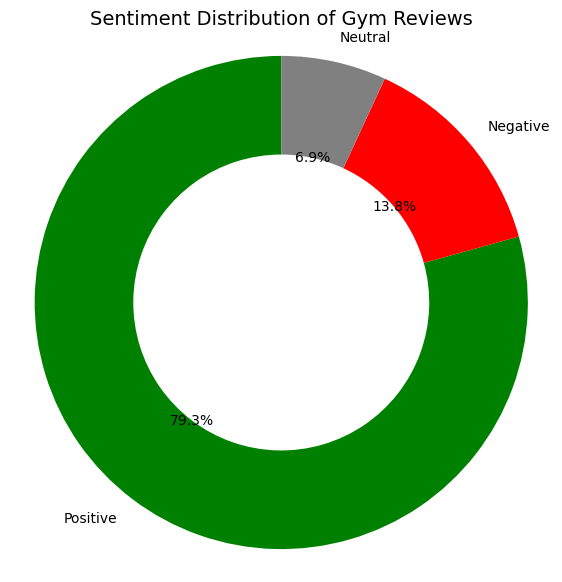

In [19]:
# Function to plot sentiment donut chart
def plot_sentiment_donut_chart(reviews_df):
    sentiment_counts = reviews_df['textblob_sentiment'].value_counts()
    
    # Define colors for each sentiment
    sentiment_colors = {
        'Positive': 'green',
        'Negative': 'red',
        'Neutral': 'grey'
    }
    
    # Create a donut chart
    plt.figure(figsize=(7, 7))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, 
            colors=[sentiment_colors.get(sentiment, 'grey') for sentiment in sentiment_counts.index],
            autopct='%1.1f%%', startangle=90, wedgeprops={'width': 0.4})
    
    # Add a center circle to make it a donut chart
    centre_circle = plt.Circle((0,0), 0.20, fc='white')
    plt.gca().add_artist(centre_circle)
    
    # Display the plot with title
    plt.title('Sentiment Distribution of Gym Reviews', fontsize=14)
    plt.axis('equal')  
    plt.show()

# Collect reviews and analyze sentiment
reviews_df = collect_reviews(API_KEY, DEFAULT_TERM, DEFAULT_LOCATION)
reviews_df = analyze_sentiments(reviews_df)

# Plot the sentiment donut chart
plot_sentiment_donut_chart(reviews_df)

## Cleaning the reviews 

In [21]:
# create function to clean the review text
def clean_review(review_text):
    # Remove punctuation and non-alphabetic characters
    review_text = ''.join([char for char in review_text if char.isalpha() or char.isspace()])

    # Tokenize the review
    word_tokens = word_tokenize(review_text.lower())  # Convert to lowercase and tokenize

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    cleaned_text = [word for word in word_tokens if word not in stop_words]

    # Join the cleaned words back into a single string
    return ' '.join(cleaned_text)

# Apply the clean_review function to the reviews in the DataFrame
reviews_df['cleaned_review'] = reviews_df['review'].apply(clean_review)

# print the cleaned reviews
print(reviews_df[['business_name', 'cleaned_review']].head())  # printing out the first 5 cleaned reviews 

  business_name                                     cleaned_review
0          Base  stepping gym feels like entering sanctuary wel...
1          Base  like periodic reviews base gym christopher col...
2          Base  ultimately amenities worth cost membership cla...
3  Four Fitness  boutique gym hidden gem hamilton park area ret...
4  Four Fitness  small comforting gym everything need used work...


In [23]:
reviews_df['cleaned_review'] # printing out the cleaned reviews 

0     stepping gym feels like entering sanctuary wel...
1     like periodic reviews base gym christopher col...
2     ultimately amenities worth cost membership cla...
3     boutique gym hidden gem hamilton park area ret...
4     small comforting gym everything need used work...
5     attend hamilton park location great things say...
6     wonderful staff although air conditioning coul...
7     nice gym decent equipment many muscle headsgym...
8     primary issue basically size gym limited optio...
9     ive going gym since started crossfit new area ...
10    recently moved back jersey city search home gy...
11    ive coming train kim years never life able con...
12    best gym jc personal touch every instructor pr...
13    surge got best shape life wedding day carefull...
14    best place get trainer small group environment...
15    im writing review vote appreciation trainer re...
16    staff really nice gym crowded get workout done...
17    possible must give negative stars blink su

## Creating the wordcloud 

Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/M_6BIcBpJkMw_ctQa203-A/reviews ...
Querying https://api.yelp.com/v3/businesses/8cicyQ8j8YETAeOTcLqXKg/reviews ...
Querying https://api.yelp.com/v3/businesses/OnP7Oj26mp3KQXfjRhxhbg/reviews ...
Querying https://api.yelp.com/v3/businesses/b1izLnJRUk2_9tLhOtkSCA/reviews ...
Querying https://api.yelp.com/v3/businesses/z1PzOjI6hwie850KH_pvdQ/reviews ...
Querying https://api.yelp.com/v3/businesses/HnVLDq7iywnLdTeUlk_gtQ/reviews ...
Querying https://api.yelp.com/v3/businesses/HDTrv1gXoOOeMvQ04ehzRA/reviews ...
Querying https://api.yelp.com/v3/businesses/8YnFKNYTiBa1L-6OVgp5rA/reviews ...
Querying https://api.yelp.com/v3/businesses/0T88HCCZjHW5AJnloL_UDg/reviews ...
Querying https://api.yelp.com/v3/businesses/2UPqLPZTCyIvGtYfOnjCTw/reviews ...
Querying https://api.yelp.com/v3/businesses/C9N_-wnhQhcI6teGrqHeJA/reviews ...
Querying https://api.yelp.com/v3/businesses/nTrTiWqBfLjdxjg6DmAFtA/reviews .

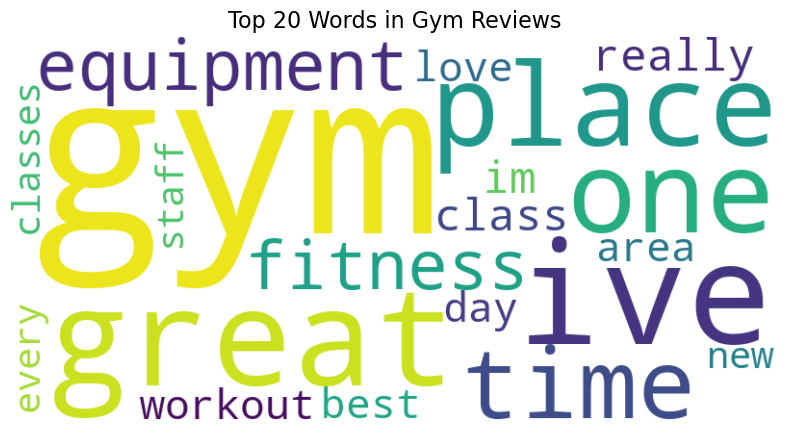

In [25]:
# Function to create a word cloud from review texts, showing only top 20 words
def create_wordcloud(reviews_df):
    # Clean reviews before creating the word cloud
    cleaned_reviews = ' '.join(reviews_df['review'].apply(clean_review))

    # Generate the word cloud, limiting it to 20 words
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=20).generate(cleaned_reviews)

    # Displaying the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide axes
    plt.title('Top 20 Words in Gym Reviews', fontsize=16)
    plt.show()

# Collect reviews and analyze sentiment
reviews_df = collect_reviews(API_KEY, DEFAULT_TERM, DEFAULT_LOCATION)
reviews_df = analyze_sentiments(reviews_df)

# Create the word cloud from the reviews, displaying top 20 words
create_wordcloud(reviews_df)

## Finding the top 5 gyms based on rating and positive sentiment 

In [27]:
# Function to get the top 5 gyms based on rating and positive sentiment
def get_top_gyms(api_key, term, location, min_reviews=10):
    # Collect reviews data
    reviews_df = collect_reviews(api_key, term, location)
    
    # Perform sentiment analysis on the reviews
    reviews_df = analyze_sentiments(reviews_df)
    
    # Filter for positive sentiment gyms
    positive_sentiment_gym_data = reviews_df[reviews_df['textblob_sentiment'] == 'Positive']
    
    # Ensure no missing values in 'rating' column
    positive_sentiment_gym_data = positive_sentiment_gym_data.dropna(subset=['rating'])
    
    # Aggregate data for each gym
    gym_sentiment_data = positive_sentiment_gym_data.groupby('business_name').agg({
        'rating': 'mean',  # Average rating
        'textblob_sentiment': 'count'  # Count of positive sentiment reviews
    }).reset_index()

    # Sort gyms by rating and count of positive sentiment reviews (descending)
    gym_sentiment_data_sorted = gym_sentiment_data.sort_values(by=['rating', 'textblob_sentiment'], ascending=False)

    # Get top 5 gyms
    top_5_gyms = gym_sentiment_data_sorted.head(5)

    # Print the results
    print("Top 5 Gyms Based on Rating and Positive Sentiment:")
    for index, gym in top_5_gyms.iterrows():
        print(f"Gym: {gym['business_name']}, Rating: {gym['rating']}, Positive Sentiment Count: {gym['textblob_sentiment']}")
    
# Call the function to get and print the top 5 gyms
get_top_gyms(API_KEY, DEFAULT_TERM, DEFAULT_LOCATION)

Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/M_6BIcBpJkMw_ctQa203-A/reviews ...
Querying https://api.yelp.com/v3/businesses/8cicyQ8j8YETAeOTcLqXKg/reviews ...
Querying https://api.yelp.com/v3/businesses/OnP7Oj26mp3KQXfjRhxhbg/reviews ...
Querying https://api.yelp.com/v3/businesses/b1izLnJRUk2_9tLhOtkSCA/reviews ...
Querying https://api.yelp.com/v3/businesses/z1PzOjI6hwie850KH_pvdQ/reviews ...
Querying https://api.yelp.com/v3/businesses/HnVLDq7iywnLdTeUlk_gtQ/reviews ...
Querying https://api.yelp.com/v3/businesses/HDTrv1gXoOOeMvQ04ehzRA/reviews ...
Querying https://api.yelp.com/v3/businesses/8YnFKNYTiBa1L-6OVgp5rA/reviews ...
Querying https://api.yelp.com/v3/businesses/0T88HCCZjHW5AJnloL_UDg/reviews ...
Querying https://api.yelp.com/v3/businesses/2UPqLPZTCyIvGtYfOnjCTw/reviews ...
Querying https://api.yelp.com/v3/businesses/C9N_-wnhQhcI6teGrqHeJA/reviews ...
Querying https://api.yelp.com/v3/businesses/nTrTiWqBfLjdxjg6DmAFtA/reviews .

## Conclusion: This analysis is based on gym reviews from the Yelp website. We have identified the top five highly rated gyms with the best sentiments. The top gyms are Heights Fitness, Ryan Rossman, Snap Fitness, Ironbound Performance Athletics, and Jane Do. All of these gyms have ratings between 4.9 and 5.0.